# Overview: DayCent regional results for BETO ABM project

This Jupyter Notebook is designed to facilitate post-processing and analysis of sets of raw DayCent results from regional-scale simulation of the following feedstock production scenarios in the US Corn Belt:
* Business-as-usual cultivation of corn and soybeans in rotation
* New harvest of corn stover as a cellulosic biomass feedstock
* New cultivation of switchgrass on abandoned cropland in the area

The corn–soy analysis consists of reanalyzing previously-generated intermediary results. The switchgrass results are derived from a full analysis of raw DayCent model output data, and will be included as a separate notebook (forthcoming).

For more information, contact author [John Field](https://johnlfield.weebly.com/) at <john.L.field@gmail.com>

## DayCent background
DayCent is a process-based model that simulates agro-ecosystem net primary production, soil organic matter dynamics, and nitrogen (N) cycling and trace gas emissions. DayCent is a daily-timestep version of the older CENTURY model. Both models were created and are currently maintained at the Colorado State University [Natural Resource Ecology Laboratory](https://www.nrel.colostate.edu/) (CSU-NREL), and source code is available upon request. 
![Alt text](DayCent.png)

DayCent model homepage:  [https://www2.nrel.colostate.edu/projects/daycent/](https://www2.nrel.colostate.edu/projects/daycent/)

In bioenergy sustainability studies, DayCent is typically used to estimate:
* yields (both grain and biomass, where appropriate)
* annual emissions of nitrous oxide (N2O), a potent greenhouse gas (GHG) generated in soils from synthetic and organic nitrogen fertilizer
* changes in soil organic carbon (SOC) levels over time

## Regional simulation workflow
The primary spatial data inputs to DayCent are:
* soil texture as a function of depth
* historic daily weather (Tmin, Tmax, precip)

Our DayCent spatial modeling workflow is based on a national-scale GIS database of current land use ([NLCD](https://www.mrlc.gov/national-land-cover-database-nlcd-2016)), soil ([SSURGO](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/?cid=nrcs142p2_053627)), and weather ([NARR](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/north-american-regional-reanalysis-narr)) data layers housed at CSU-NREL. The python-based workflow consists of a collection of scripts that perform the following:
1. Selection of area to be simulated, specified based on current land cover and/or land biophysical factors (i.e., soil texutre, slope, land capability class rating, etc.)
2. Determination of individual unique DayCent model runs (i.e., **"strata"**) necessary to cover the heterogenity of soils and climate across the simulation area
3. Parallel execution of simulations on the CSU-NREL computing cluster
4. Results analysis and mapping (this routine)

## Glossary
- BAU = business-as-usual, describing the performance of the system in the absence of any change in management
- treatment = a feedstock production scenario involving a change in management of the system relative to BAU. 
- FIPS = Federal 5-digit code identifying counties. First two digits denote the state. Note that some of these codes start with a leading zero, so they are stored as a string datatype

## Metadata

All results data are compiled to county scale. The following data columns are included:
- aspectrep (SSURGO) = The common, typical, or expected direction toward which the surface of the soil faces, expressed as an angle between 0 and 360 degrees measured clockwise from true north. {degree}

# Loading Python modules

In [1]:
# import the necessary modules

import constants as cons
from IPython.display import Image, display
import json
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import os
import pandas as pd
import plotly.express as px
from urllib.request import urlopen

In [2]:
# defining paths

root_dir = os.path.join(os.getcwd())
data_dir = os.path.join(root_dir, 'intermediate_data')
results_dir = os.path.join(root_dir, 'tabular_results')
map_dir = os.path.join(root_dir, 'maps')

# Processing corn–soy simulation data

The code below loads partially-analyzed DayCent simulation results at the county scale into Pandas dataframes for furhter analysis. Results are included for four different management scenarios that were simulated:
* no stover removal (G, i.e., grain harvest only)
* 25% stover harvest (G25S)
* 50% stover harvest (G50S)
* 75% stover harvest (G75S)

Simulation results are spread across multiple .csv-format results files as follows:
* corn–soy area per county (area_fips_data.csv)
* annual simulated corn yields per county (corn_yield_year_county.csv)
* annual simulated soy yields per county (soybean_yield_year_county.csv)
* annual simulated stover yields per county (Stover_yield_year_county.csv)
* annual simulated SOC levels per county (SOC_year_county.csv)
* annual simulated N2O emissions per county (N2O_year_county.csv)

## Importing summary data

In [3]:
# import various data files from the 'intermediate_data' directory

area_df = pd.read_csv(os.path.join(data_dir, "area_fips_data.csv"), usecols=[1, 2])
corn_df = pd.read_csv(os.path.join(data_dir, "corn_yield_year_county.csv"), usecols=[1, 2, 3, 4])
soy_df = pd.read_csv(os.path.join(data_dir, "soybean_yield_year_county.csv"), usecols=[1, 2, 3, 4])
stover_df = pd.read_csv(os.path.join(data_dir, "Stover_yield_year_county.csv"), usecols=[1, 2, 3, 4])
soc_df = pd.read_csv(os.path.join(data_dir, "SOC_year_county.csv"), usecols=[1, 2, 3, 4])
n2o_df = pd.read_csv(os.path.join(data_dir, "N2O_year_county.csv"), usecols=[1, 2, 3, 4])

# display one representative set of results
soc_df

,fips,simyear,stover_removal,SOC_20cm_g_m2
0,17001,2011,G,6163.79256
1,17001,2011,G25S,6163.65078
2,17001,2011,G50S,6163.45078
3,17001,2011,G75S,6163.21790
4,17001,2012,G,6238.24324
...,...,...,...,...
72595,55139,2039,G75S,4482.88127
72596,55139,2040,G,5133.82478
72597,55139,2040,G25S,4911.76100
72598,55139,2040,G50S,4689.96280


## Unit conversions

In the following operations I'm updating to more formal units using the conversion factors in constants.py. I keep track of the updated units in the column names. For simplicity, after each conversion, I drop the original data in now-obsolete units.

In [4]:
# perform unit conversions and drop original data columns

area_df["area_ha"] = area_df["area_acres"] * cons.ha_per_ACRE
area_df.drop(columns=["area_acres"], inplace=True)

corn_df["corn_yield_Mg_ha"] = corn_df["grainyield_bu_ac"
                                     ] * ((cons.kg_per_bu_CORN * 0.001) / cons.ha_per_ACRE)
corn_df.drop(columns=["grainyield_bu_ac"], inplace=True)

soy_df["soy_yield_Mg_ha"] = soy_df["grainyield_bu_ac"
                                  ] * ((cons.kg_per_bu_SOY * 0.001) / cons.ha_per_ACRE)
soy_df.drop(columns=["grainyield_bu_ac"], inplace=True)

stover_df["stover_yield_Mg_ha"] = stover_df["stover_dryyield_kgha"] * 0.001
stover_df.drop(columns=["stover_dryyield_kgha"], inplace=True)

soc_df["SOC_MgC_ha"] = soc_df["SOC_20cm_g_m2"] * cons.g_m2_to_Mg_ha
soc_df.drop(columns=["SOC_20cm_g_m2"], inplace=True)

n2o_df["N2O_MgCO2e_ha"] = n2o_df["N2O_gN_m2"
                                ] * cons.g_m2_to_Mg_ha * cons.N_to_N2O * cons.N2O_GWP100_AR5
n2o_df.drop(columns=["N2O_gN_m2"], inplace=True)

# display one representative set of results
soc_df

,fips,simyear,stover_removal,SOC_MgC_ha
0,17001,2011,G,61.637926
1,17001,2011,G25S,61.636508
2,17001,2011,G50S,61.634508
3,17001,2011,G75S,61.632179
4,17001,2012,G,62.382432
...,...,...,...,...
72595,55139,2039,G75S,44.828813
72596,55139,2040,G,51.338248
72597,55139,2040,G25S,49.117610
72598,55139,2040,G50S,46.899628


## Annual SOC differences

I implemented this by ordering the data by fips|treatment|time, computing row differences, and then dropping the first year of each series (which reflects a difference between treatments instead of between years).

In [5]:
# order SOC DataFrame and compute annual differences

soc_df = soc_df.sort_values(["fips", "stover_removal", "simyear"])
soc_df["dSOC_MgC_ha"] = soc_df["SOC_MgC_ha"].diff()
soc_df["dSOC_MgCO2e_ha"] = soc_df["SOC_MgC_ha"] * cons.C_to_CO2
soc_df = soc_df[(soc_df["simyear"] != 2011)]

soc_df

,fips,simyear,stover_removal,SOC_MgC_ha,dSOC_MgC_ha,dSOC_MgCO2e_ha
4,17001,2012,G,62.382432,0.744507,228.572847
8,17001,2013,G,62.883798,0.501366,230.409881
12,17001,2014,G,63.421484,0.537686,232.379993
16,17001,2015,G,63.768391,0.346907,233.651081
20,17001,2016,G,64.530508,0.762116,236.443519
...,...,...,...,...,...,...
72583,55139,2036,G75S,44.601332,-0.167837,163.421864
72587,55139,2037,G75S,44.624665,0.023333,163.507359
72591,55139,2038,G75S,44.583367,-0.041298,163.356039
72595,55139,2039,G75S,44.828813,0.245446,164.255367


## Data aggregation & merges

Here I calculate mean yields, N2O emissions & SOC changes over the full course of the simulation, and then merge all results together into a single data frame. Note that the aggregation has to come before the merges, since corn & soy are harvested in alternate years and thus cannot be merged on 'simyear'. Also, note that all year 2011 yield results are dropped on merge, since there are no dSOC results for that year.

In [6]:
# group each DataFrame by county & scenario, calculting time-average results

corn_df = corn_df[["fips", "stover_removal", "corn_yield_Mg_ha"]
                 ].groupby(["fips", "stover_removal"]).mean()
soy_df = soy_df[["fips", "stover_removal", "soy_yield_Mg_ha"]
               ].groupby(["fips", "stover_removal"]).mean()
stover_df = stover_df[["fips", "stover_removal", "stover_yield_Mg_ha"]
                     ].groupby(["fips", "stover_removal"]).mean()
soc_df = soc_df[["fips", "stover_removal", "dSOC_MgCO2e_ha"]
               ].groupby(["fips", "stover_removal"]).mean()
n2o_df = n2o_df[["fips", "stover_removal", "N2O_MgCO2e_ha"]
               ].groupby(["fips", "stover_removal"]).mean()

In [7]:
# merge all results on county & scenario, then drop the index

df = pd.merge(corn_df, soy_df, on=['fips', 'stover_removal'])
df = pd.merge(df, stover_df, on=['fips', 'stover_removal'])
df = pd.merge(df, soc_df, on=['fips', 'stover_removal'])
df = pd.merge(df, n2o_df, on=['fips', 'stover_removal'])
df.reset_index(inplace=True)

df = pd.merge(df, area_df, on='fips')

In [8]:
# change to more descriptive stover removal scenario names

dict = {'G': 'no_stover_BAU',
        'G25S' : '25pct_stover',
        'G50S' : '50pct_stover',
        'G75S' : '75pct_stover'} 

df['stover_removal']= df['stover_removal'].map(dict) 

In [9]:
# calculate total GHG emissions

df['GHG_MgCO2e_ha'] = df['N2O_MgCO2e_ha'] - df['dSOC_MgCO2e_ha']
df

,fips,stover_removal,corn_yield_Mg_ha,soy_yield_Mg_ha,stover_yield_Mg_ha,dSOC_MgCO2e_ha,N2O_MgCO2e_ha,area_ha,GHG_MgCO2e_ha
0,17001,no_stover_BAU,12.167596,3.781892,0.000000,251.257136,1.480206,90892.4756,-249.776930
1,17001,25pct_stover,12.163762,3.792497,3.171844,243.544698,1.450169,90892.4756,-242.094529
2,17001,50pct_stover,12.156676,3.801587,6.340456,235.729660,1.400454,90892.4756,-234.329206
3,17001,75pct_stover,12.139374,3.811355,9.499163,227.628359,1.378496,90892.4756,-226.249862
4,17003,no_stover_BAU,10.814741,3.704946,0.000000,169.767187,1.285088,11007.4592,-168.482099
...,...,...,...,...,...,...,...,...,...
2415,55133,75pct_stover,10.904004,3.360029,8.453953,217.616488,1.332299,6394.0388,-216.284189
2416,55139,no_stover_BAU,11.163102,3.514759,0.000000,180.493138,1.182596,6636.8504,-179.310543
2417,55139,25pct_stover,11.153444,3.516110,2.979155,174.963897,1.171707,6636.8504,-173.792190
2418,55139,50pct_stover,11.143157,3.517085,5.952131,169.448014,1.136544,6636.8504,-168.311470


## County production totals

In [10]:
# calculate county data totals

data_cols = ['corn_yield_Mg_ha', 'soy_yield_Mg_ha', 'stover_yield_Mg_ha',
             'dSOC_MgCO2e_ha', 'N2O_MgCO2e_ha', 'GHG_MgCO2e_ha']

for col in data_cols:
    df[col[:-3]] = df[col] * df['area_ha']

In [11]:
# calculate total production, accounting for rotation
for col in ['corn_yield_Mg', 'soy_yield_Mg', 'stover_yield_Mg']:
    df[col[:-8]+'prod_Mt_y'] = df[col] * 0.5 * 1e-6
    df.drop(columns=[col], inplace=True)

# convert GHG fluxes to like Mt units
for col in ['dSOC_MgCO2e', 'N2O_MgCO2e', 'GHG_MgCO2e']:
    df[col[:-6]+'MtCO2e'] = df[col] * 1e-6
    df.drop(columns=[col], inplace=True)

df

,fips,stover_removal,corn_yield_Mg_ha,soy_yield_Mg_ha,stover_yield_Mg_ha,dSOC_MgCO2e_ha,N2O_MgCO2e_ha,area_ha,GHG_MgCO2e_ha,corn_prod_Mt_y,soy_prod_Mt_y,stover_prod_Mt_y,dSOC_MtCO2e,N2O_MtCO2e,GHG_MtCO2e
0,17001,no_stover_BAU,12.167596,3.781892,0.000000,251.257136,1.480206,90892.4756,-249.776930,0.552971,0.171873,0.000000,22.837383,0.134540,-22.702844
1,17001,25pct_stover,12.163762,3.792497,3.171844,243.544698,1.450169,90892.4756,-242.094529,0.552797,0.172355,0.144148,22.136380,0.131809,-22.004571
2,17001,50pct_stover,12.156676,3.801587,6.340456,235.729660,1.400454,90892.4756,-234.329206,0.552475,0.172768,0.288150,21.426052,0.127291,-21.298762
3,17001,75pct_stover,12.139374,3.811355,9.499163,227.628359,1.378496,90892.4756,-226.249862,0.551689,0.173212,0.431701,20.689705,0.125295,-20.564410
4,17003,no_stover_BAU,10.814741,3.704946,0.000000,169.767187,1.285088,11007.4592,-168.482099,0.059521,0.020391,0.000000,1.868705,0.014146,-1.854560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2415,55133,75pct_stover,10.904004,3.360029,8.453953,217.616488,1.332299,6394.0388,-216.284189,0.034860,0.010742,0.027027,1.391448,0.008519,-1.382929
2416,55139,no_stover_BAU,11.163102,3.514759,0.000000,180.493138,1.182596,6636.8504,-179.310543,0.037044,0.011663,0.000000,1.197906,0.007849,-1.190057
2417,55139,25pct_stover,11.153444,3.516110,2.979155,174.963897,1.171707,6636.8504,-173.792190,0.037012,0.011668,0.009886,1.161209,0.007776,-1.153433
2418,55139,50pct_stover,11.143157,3.517085,5.952131,169.448014,1.136544,6636.8504,-168.311470,0.036978,0.011671,0.019752,1.124601,0.007543,-1.117058


## Join county names & save

In [12]:
# load look-up table of all US FIPS codes & join to results
fips_df = pd.read_csv('FIPS_codes.csv')
fips_df.rename(columns={'FIPS': 'fips'}, inplace=True)

# join 
df = pd.merge(fips_df[['fips', 'County', 'ST']], df, on=['fips'])
df

,fips,County,ST,stover_removal,corn_yield_Mg_ha,soy_yield_Mg_ha,stover_yield_Mg_ha,dSOC_MgCO2e_ha,N2O_MgCO2e_ha,area_ha,GHG_MgCO2e_ha,corn_prod_Mt_y,soy_prod_Mt_y,stover_prod_Mt_y,dSOC_MtCO2e,N2O_MtCO2e,GHG_MtCO2e
0,17001,Adams,IL,no_stover_BAU,12.167596,3.781892,0.000000,251.257136,1.480206,90892.4756,-249.776930,0.552971,0.171873,0.000000,22.837383,0.134540,-22.702844
1,17001,Adams,IL,25pct_stover,12.163762,3.792497,3.171844,243.544698,1.450169,90892.4756,-242.094529,0.552797,0.172355,0.144148,22.136380,0.131809,-22.004571
2,17001,Adams,IL,50pct_stover,12.156676,3.801587,6.340456,235.729660,1.400454,90892.4756,-234.329206,0.552475,0.172768,0.288150,21.426052,0.127291,-21.298762
3,17001,Adams,IL,75pct_stover,12.139374,3.811355,9.499163,227.628359,1.378496,90892.4756,-226.249862,0.551689,0.173212,0.431701,20.689705,0.125295,-20.564410
4,17003,Alexander,IL,no_stover_BAU,10.814741,3.704946,0.000000,169.767187,1.285088,11007.4592,-168.482099,0.059521,0.020391,0.000000,1.868705,0.014146,-1.854560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2415,55133,Waukesha,WI,75pct_stover,10.904004,3.360029,8.453953,217.616488,1.332299,6394.0388,-216.284189,0.034860,0.010742,0.027027,1.391448,0.008519,-1.382929
2416,55139,Winnebago,WI,no_stover_BAU,11.163102,3.514759,0.000000,180.493138,1.182596,6636.8504,-179.310543,0.037044,0.011663,0.000000,1.197906,0.007849,-1.190057
2417,55139,Winnebago,WI,25pct_stover,11.153444,3.516110,2.979155,174.963897,1.171707,6636.8504,-173.792190,0.037012,0.011668,0.009886,1.161209,0.007776,-1.153433
2418,55139,Winnebago,WI,50pct_stover,11.143157,3.517085,5.952131,169.448014,1.136544,6636.8504,-168.311470,0.036978,0.011671,0.019752,1.124601,0.007543,-1.117058


In [13]:
# data export

df.to_csv(os.path.join(results_dir, 'corn-stover_county_results.csv'), index=False)

# Mapping results

Below we use the Plotly Express choropleth_mapbox function to create maps of select county-scale results. This is a relatively broad, high-level function (compared to the Plotly Figure Factory or Graph Objects functions) that creates interactive maps with automatic color scaling. Notes:
- This mapping requires downloading a JSON shapefile of county boundaries.
- **Interactive Plotly mapping objects are large (>10MB), and notebooks with multiple embedded mapping objects will exceed the maximum GitHub file size. The 'interactive_map' parameter should be set to False prior to committing to GitHub, which will save high-resolution PDF versions of all maps, and replace the interactive Plotly mapping objects with an embedded static PNG-formatted copy of the map.**
- Figure panels are created and exported individually to facilitate debugging and iterative refinement. Panel sizing is tuned for best fit in 80mm or 180mm (i.e., standard journal 1- or 2-column) widths. Multi-panel publication-quality figures should be assembled in PowerPoint, as necessary.
- PDF outputs have an extra blank page.

In [14]:
# import shapefile of county boundaries
shapeurl = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'
with urlopen(shapeurl) as response:
    counties = json.load(response)

# define lat/long/zoom factors appropriate for visualizing the Corn Belt
map_width = 340   # pixels
aspect_ratio = 0.64
map_zoom = 3.0
cen_lat = 41.8
cen_lon = -89.8
prod_lim = 1.0
prod_colors = 'deep'

# define standard plot limits across crops
yield_lims = [0, 25.0]  # (Mg ha-1 y-1)
area_lims = [0, 1.0e5]  # (ha)
prod_lims = [0, 1.0]  # (Mt y-1)

# In interactive mapping mode, live Plotly maps maps are displayed. If false, static maps
# are saved in PNG & PDF formats, and the static PNG map is displayed
interactive_map = False


def mapping(df, data_column, colorscale, label, kwargs={}):
    my_map = px.choropleth_mapbox(df, geojson=counties, locations='fips',
                                  color=data_column,
                                  color_continuous_scale=colorscale,
                                  mapbox_style='open-street-map',
                                  zoom=map_zoom, center={"lat": cen_lat, "lon": cen_lon},
                                  labels={data_column: label},
                                  **kwargs)
    my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                         margin={"r":0,"t":0,"l":0,"b":0})
    if interactive_map:
        my_map.show()
    else:
        my_map.write_image(os.path.join(map_dir, data_column + ".pdf"))
        my_map.write_image(os.path.join(map_dir, data_column + ".png"))
        display(Image(filename=os.path.join(map_dir, data_column + ".png"))) 

## Absolute results

In [15]:
# since scenario data is still stacked, we need to filter DataFrame by scenario for plotting

scenario = '50pct_stover'
corn_df = df[df.stover_removal == scenario]

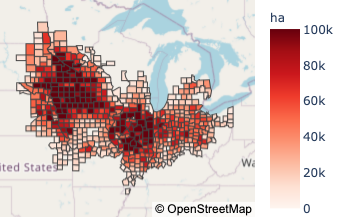

In [16]:
mapping(corn_df, 'area_ha', 'reds', 'ha',
        kwargs={"range_color": area_lims})

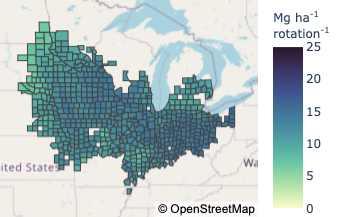

In [17]:
mapping(corn_df, 'corn_yield_Mg_ha', 'deep', 'Mg ha<sup>-1</sup><br>rotation<sup>-1</sup>',
        kwargs={"range_color": yield_lims})

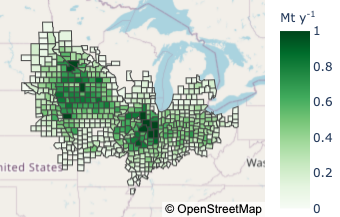

In [18]:
mapping(corn_df, 'corn_prod_Mt_y', 'Greens', 'Mt y<sup>-1</sup>',
        kwargs={"range_color": prod_lims})

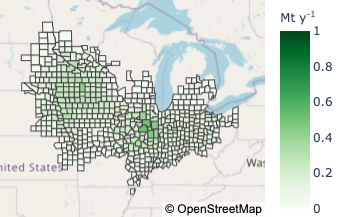

In [19]:
mapping(corn_df, 'soy_prod_Mt_y', 'Greens', 'Mt y<sup>-1</sup>',
        kwargs={"range_color": prod_lims})

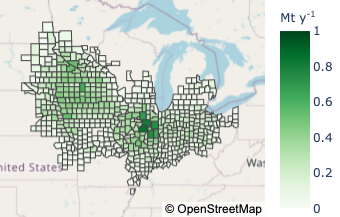

In [20]:
mapping(corn_df, 'stover_prod_Mt_y', 'Greens', 'Mt y<sup>-1</sup>',
        kwargs={"range_color": prod_lims})

## Scenario comparison

This operation re-shapes the data such that the results for different management treatments (e.g., G, G25S, etc.) are shown in different columns instead of different rows. After the pivot step, we compute SOC and N2O differences between treatments. 

In [21]:
# # scenario to compare to BAU baseline
# test_scen = '25pct_stover'

# # make a copy of the DataFrame, w/o the area column
# piv_cols = ['fips', 'stover_removal',
#             'corn_prod_Mt_y', 'soy_prod_Mt_y', 'stover_prod_Mt_y',
#             'dSOC_MtCO2e', 'N2O_MtCO2e', 'GHG_MtCO2e']
# piv_df = df[df.stover_removal.isin([test_scen, 'no_stover_BAU'])][piv_cols].copy(deep=False)

# # perform the pivot
# piv_df = piv_df.pivot(index='fips', columns='stover_removal')
# piv_df = piv_df.swaplevel(0, 1, 1).sort_index(1)

# # flatten the resulting columnn multiindex
# piv_df.columns = piv_df.columns.map('|'.join).str.strip('|')
# piv_df.reset_index(inplace=True)

# piv_df

In [22]:
# # calculate normalized scenario differences

# cols = ['corn_prod_Mt_y', 'soy_prod_Mt_y', 'stover_prod_Mt_y',
#         'dSOC_MtCO2e', 'N2O_MtCO2e', 'GHG_MtCO2e']

# for col in cols:
#     piv_df[col+"_diff"] = piv_df[test_scen+'|'+col] - piv_df['no_stover_BAU|'+col]

# # normalize GHG impacts by new stover production
# cols = ['dSOC_MtCO2e', 'N2O_MtCO2e', 'GHG_MtCO2e']
# for col in cols:
#     piv_df[col+"_MtStover"] = piv_df[col+"_diff"] / piv_df['stover_prod_Mt_y_diff']

# piv_df

In [23]:
# mapping(piv_df, 'GHG_MtCO2e_MtStover', 'Reds',
#         'Mt CO<sub>2</sub>e<br>(Mt biomass)<sup>-1</sup>')

# Misc.

Remaining To-Do:
* finish up glossary & metadata
* research 'tidy' format in Pandas
* Add in 'tidy data' links (both original & pandas-version)

In [24]:
## leftover code fragments for switchgrass

# corn_fips = corn_df['fips']
# corn_fips

# switch_file = "/Users/johnfield/Desktop/CBI_mapping/CBI_baseline-county_scale_results.csv"
# switch_df = pd.read_csv(switch_file, usecols=['fips', 'tot_ha', 'yield_Mg', 'yield_Mg_ha', 'county', 'ST'])
# switch_df

# switch_df = pd.merge(switch_df, corn_fips, on='fips')
# switch_df['switch_prod_Mt_y'] = switch_df['yield_Mg'] * 1e-6
# switch_df

# mapping(switch_df, 'tot_ha', 'reds', 'ha',
#         kwargs={"range_color": area_lims})

# mapping(switch_df, 'yield_Mg_ha', 'Greens', 'Mg ha<sup>-1</sup><br>y<sup>-1</sup>',
#         kwargs={"range_color": yield_lims})

# mapping(switch_df, 'switch_prod_Mt_y', 'deep', 'Mt y<sup>-1</sup>',
#         kwargs={"range_color": prod_lims})